In [65]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms

from PIL import Image
from tqdm import trange
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import os
import random
import shutil
import cv2
import yaml


In [66]:
SEED = 33

In [67]:
dataset_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"  # adjust to your root folder
classes = ["Parasitized", "Uninfected"]

img_paths = []
labels = []

for cls in classes:
    cls_dir = os.path.join(dataset_dir, cls)
    print(cls_dir)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(cls_dir, fname)
            img_paths.append(path)
            labels.append(cls) 

dataset = pd.DataFrame({
    "image_path": img_paths,
    "label": labels})

print(dataset.head())
print(dataset['label'].value_counts())

/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized
/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected
                                          image_path        label
0  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
1  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
2  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
3  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
4  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
label
Parasitized    13779
Uninfected     13779
Name: count, dtype: int64


In [68]:
# install ultralytics
# !pip install ultralytics

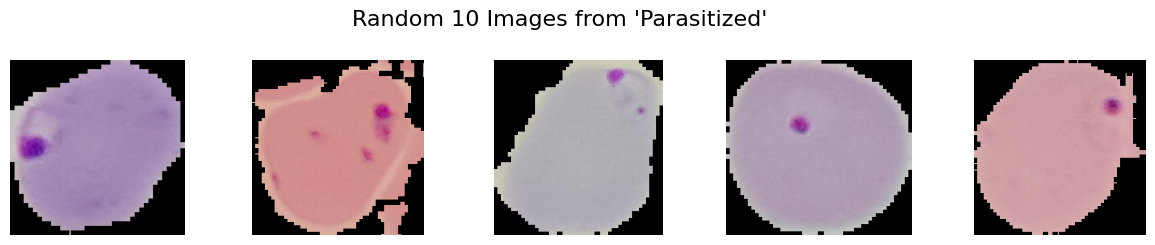

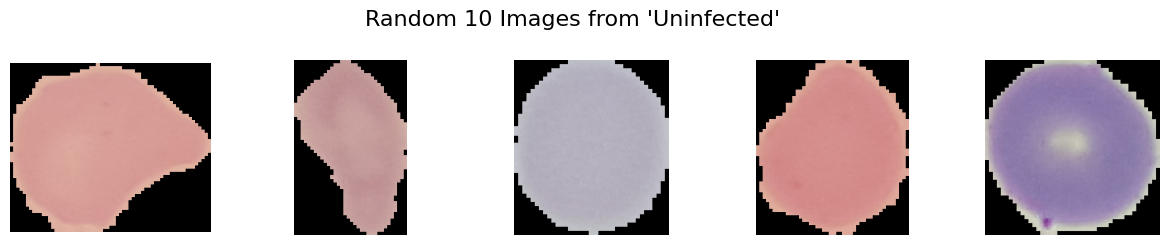

In [69]:
# view the data(10 parasitized, 10 uninfected)
labels = dataset['label'].unique()

for label in labels:
    # randomly select 10 images for this label
    sample_df = dataset[dataset["label"] == label].sample(5, random_state=SEED)

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Random 10 Images from '{label}'", fontsize=16)

    for i, path in enumerate(sample_df["image_path"].values):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert from BGR → RGB for matplotlib

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()

In [70]:
trainval_df, test_df = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=SEED)

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
trainval_df = trainval_df.reset_index(drop=True)
trainval_df['fold'] = -1

# assign each(set of) row(s) a fold number until all rows have been assigned one 
for fold, (train_idx, val_idx) in enumerate(skf.split(trainval_df, trainval_df['label'])):
    trainval_df.loc[val_idx, 'fold'] = fold

In [72]:
trainval_df.to_csv('/kaggle/working/trainval.csv', index=False)
test_df.to_csv('/kaggle/working/test.csv', index=False)

print('Saved')

Saved


In [73]:
dataset['image_path']

0        /kaggle/input/cell-images-for-detecting-malari...
1        /kaggle/input/cell-images-for-detecting-malari...
2        /kaggle/input/cell-images-for-detecting-malari...
3        /kaggle/input/cell-images-for-detecting-malari...
4        /kaggle/input/cell-images-for-detecting-malari...
                               ...                        
27553    /kaggle/input/cell-images-for-detecting-malari...
27554    /kaggle/input/cell-images-for-detecting-malari...
27555    /kaggle/input/cell-images-for-detecting-malari...
27556    /kaggle/input/cell-images-for-detecting-malari...
27557    /kaggle/input/cell-images-for-detecting-malari...
Name: image_path, Length: 27558, dtype: object

In [74]:
fold = 0

trainval_df = pd.read_csv('/kaggle/working/trainval.csv')
test_csv = pd.read_csv('/kaggle/working/test.csv')

train_df = trainval_df[trainval_df['fold'] != fold]
val_df = trainval_df[trainval_df['fold'] == fold]

train_df.to_csv('/kaggle/working/train.csv', index=False)
val_df.to_csv('/kaggle/working/val.csv', index=False)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [75]:
class Malaria(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.class_to_idx = {'Parasitized': 1, 'Uninfected':0}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Access row by *position*, not by label
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_idx = self.class_to_idx[label]
        return image, label_idx


# transforms = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406],
#     #                      std=[0.229, 0.224, 0.225])
# ])

In [76]:
# train_dataset_obj = Malaria(train_df, transform=transforms)
# val_dataset_obj = Malaria(val_df, transform=transforms)
# test_dataset_obj = Malaria(test_csv, transform=transforms)

# batch_size=32

# train_loader = DataLoader(train_dataset_obj, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset_obj, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset_obj, batch_size=batch_size, shuffle=False)

# print(f"Number of training batches: {len(train_loader)}")
# print(f"Number of validation batches: {len(val_loader)}")
# print(f"Number of test batches: {len(test_loader)}")

In [77]:
train_df.head()

,image_path,label,fold
0,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,1
1,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,1
2,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,2
3,/kaggle/input/cell-images-for-detecting-malari...,Uninfected,3
4,/kaggle/input/cell-images-for-detecting-malari...,Parasitized,3


In [78]:
# # --- Compute mean & std for the images ---
# mean = 0.0
# std = 0.0
# for images, _ in train_loader:  # we ignore labels using '_'
#     batch_samples = images.size(0)  # batch size
#     images = images.view(batch_samples, images.size(1), -1)  # flatten pixels per channel
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)

# mean /= len(train_loader.dataset)
# std /= len(train_loader.dataset)

# print("Mean:", mean)
# print("Std:", std)

In [79]:
import torchvision.transforms as transforms

image_size = 224

#  transform the dataset
# transform_ = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor()
#     transforms.Normalize(mean=[0.5298, 0.4242, 0.4533],
#                          std=[0.3278, 0.2643, 0.2784])
# ])

transform_ = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),     # flip image horizontally
    transforms.RandomRotation(10),              # rotate slightly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5298, 0.4242, 0.4533], std=[0.3278, 0.2643, 0.2784])   # computed mean/std
])


train_dataset_obj = Malaria(train_df, transform=transform_)
val_dataset_obj = Malaria(val_df, transform=transform_)
test_dataset_obj = Malaria(test_csv, transform=transform_)

batch_size=32

train_loader = DataLoader(train_dataset_obj, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_obj, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_obj, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 552
Number of validation batches: 138
Number of test batches: 173


### Create the utility functions 

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

train_losses, train_accuracies, val_losses, val_accuracies  = [], [], [], []

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_loss = running_loss/len(train_loader)
        train_acc = 100 * correct/total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        

        # Evaluation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Using device: cuda


In [81]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return acc, prec, rec, f1

### Train & Evaluate the model

#### Using Resnet101

In [82]:
# Using ResNet101 instead of ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Replace the final fully-connected layer for binary classification (2 classes)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

In [83]:
# Use DataParallel if more than 1 GPU is detected
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    resnet = nn.DataParallel(resnet)

train_model(resnet, criterion, optimizer, train_loader, val_loader, num_epochs=10, device=device)

Using 2 GPUs!
Epoch [1/10], Train Loss: 4.5681, Train Acc: 95.21%, Val Loss: 0.1007, Val Acc: 96.53%
Epoch [2/10], Train Loss: 3.1695, Train Acc: 96.70%, Val Loss: 0.0929, Val Acc: 96.89%
Epoch [3/10], Train Loss: 2.7037, Train Acc: 97.09%, Val Loss: 0.0904, Val Acc: 96.96%
Epoch [4/10], Train Loss: 2.3768, Train Acc: 97.49%, Val Loss: 0.1051, Val Acc: 96.60%
Epoch [5/10], Train Loss: 2.3407, Train Acc: 97.45%, Val Loss: 0.0916, Val Acc: 96.85%
Epoch [6/10], Train Loss: 2.0257, Train Acc: 97.74%, Val Loss: 0.0900, Val Acc: 96.69%
Epoch [7/10], Train Loss: 1.8875, Train Acc: 97.90%, Val Loss: 0.1080, Val Acc: 96.35%
Epoch [8/10], Train Loss: 1.7456, Train Acc: 98.07%, Val Loss: 0.0930, Val Acc: 96.92%
Epoch [9/10], Train Loss: 1.5741, Train Acc: 98.15%, Val Loss: 0.0887, Val Acc: 96.94%
Epoch [10/10], Train Loss: 1.4277, Train Acc: 98.42%, Val Loss: 0.0972, Val Acc: 97.12%


In [84]:
resnet_metrics = evaluate_model(resnet, test_loader, device=device)
print("ResNet Results:")
print(f"Accuracy:  {resnet_metrics[0]:.4f}")
print(f"Precision: {resnet_metrics[1]:.4f}")
print(f"Recall:    {resnet_metrics[2]:.4f}")
print(f"F1-score:  {resnet_metrics[3]:.4f}")

ResNet Results:
Accuracy:  0.9728
Precision: 0.9677
Recall:    0.9782
F1-score:  0.9729


#### Using VGG19

In [85]:
# Load pretrained VGG19 model
vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

# Replace the classifier (the last layers) for 2 classes
vgg19.classifier[6] = nn.Linear(4096, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=1e-4)

In [86]:
# Use DataParallel if more than 1 GPU is detected
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    vgg19 = nn.DataParallel(vgg19)

train_model(vgg19, criterion, optimizer, train_loader, val_loader, num_epochs=10, device=device)

Using 2 GPUs!
Epoch [1/10], Train Loss: 4.9842, Train Acc: 94.96%, Val Loss: 0.1370, Val Acc: 95.53%
Epoch [2/10], Train Loss: 4.0822, Train Acc: 95.93%, Val Loss: 0.1672, Val Acc: 94.72%
Epoch [3/10], Train Loss: 3.7614, Train Acc: 96.35%, Val Loss: 0.1224, Val Acc: 95.87%
Epoch [4/10], Train Loss: 3.4559, Train Acc: 96.49%, Val Loss: 0.1192, Val Acc: 96.24%
Epoch [5/10], Train Loss: 3.2962, Train Acc: 96.73%, Val Loss: 0.1144, Val Acc: 95.85%
Epoch [6/10], Train Loss: 3.0743, Train Acc: 96.73%, Val Loss: 0.1070, Val Acc: 96.17%
Epoch [7/10], Train Loss: 3.0068, Train Acc: 96.93%, Val Loss: 0.0993, Val Acc: 96.49%
Epoch [8/10], Train Loss: 2.9945, Train Acc: 96.92%, Val Loss: 0.1089, Val Acc: 96.30%
Epoch [9/10], Train Loss: 2.7568, Train Acc: 97.16%, Val Loss: 0.1124, Val Acc: 96.33%
Epoch [10/10], Train Loss: 2.6963, Train Acc: 97.20%, Val Loss: 0.1062, Val Acc: 96.42%


In [87]:
vgg19_metrics = evaluate_model(resnet, test_loader, device=device)
print("VGG19 Results:")
print(f"Accuracy:  {vgg19_metrics[0]:.4f}")
print(f"Precision: {vgg19_metrics[1]:.4f}")
print(f"Recall:    {vgg19_metrics[2]:.4f}")
print(f"F1-score:  {vgg19_metrics[3]:.4f}")

VGG19 Results:
Accuracy:  0.9728
Precision: 0.9687
Recall:    0.9771
F1-score:  0.9729


### Get Preditions

In [88]:
def get_predictions(model, dataloader, device):
    model.eval()
    test_true, test_pred, test_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            test_true.extend(labels.cpu().numpy())
            test_pred.extend(preds.cpu().numpy())
            test_probs.extend(probs[:, 1].cpu().numpy())  # class 1 probability
    return np.array(test_true), np.array(test_pred), np.array(test_probs)

# Get Predictions
resnet_true, resnet_pred, resnet_probs = get_predictions(resnet, test_loader, device)
vgg19_true, vgg19_pred, vgg19_probs = get_predictions(vgg19, test_loader, device)

<Figure size 600x500 with 0 Axes>

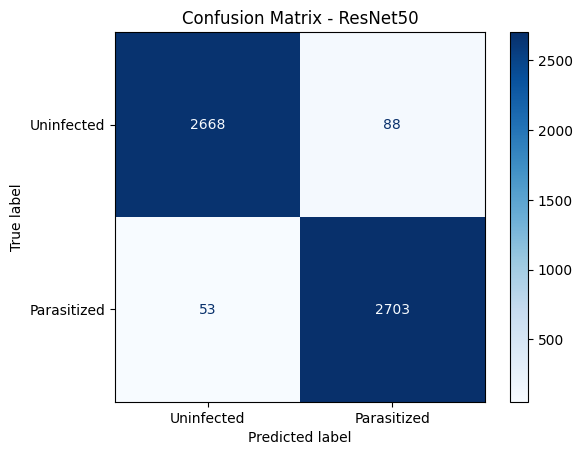

<Figure size 600x500 with 0 Axes>

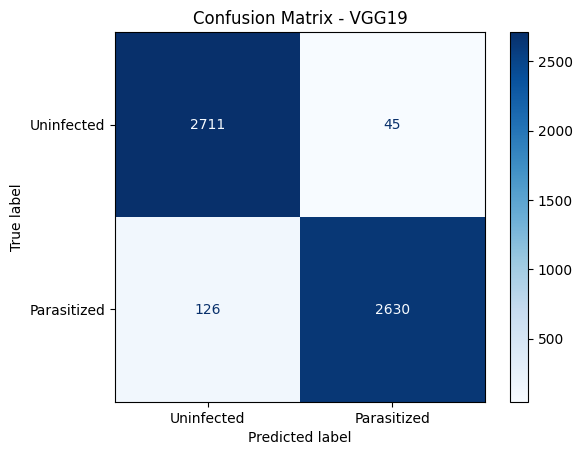

In [89]:
# Plot a confusion matrix for model predictions.
def plot_confusion_matrix(test_true, test_pred, model_name='None'):
    cm = confusion_matrix(test_true, test_pred)
    
    class_names = ['Uninfected', 'Parasitized']

    # Create display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot it
    plt.figure(figsize=(6, 5))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(resnet_true, resnet_pred, model_name='ResNet50')
plot_confusion_matrix(vgg19_true, vgg19_pred, model_name='VGG19')

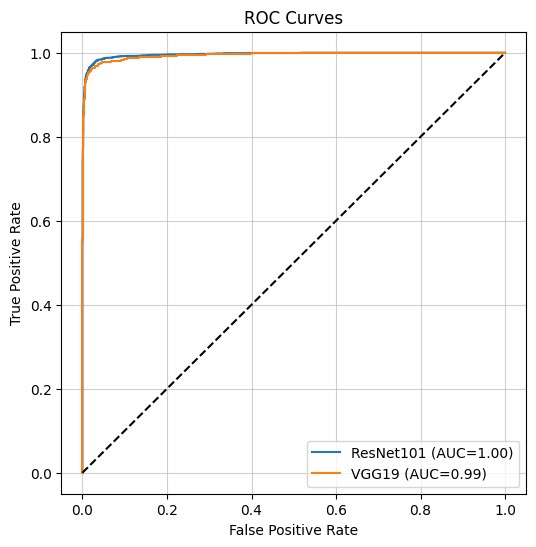

In [90]:
def plot_roc(y_true, y_probs, model):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model} (AUC={roc_auc:.2f})")

plt.figure(figsize=(6,6))
plot_roc(resnet_true, resnet_probs, "ResNet101")
plot_roc(vgg19_true, vgg19_probs, "VGG19")

# Draw a diagonal dashed line from (0,0) to (1,1)
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True, linestyle="-", alpha=0.6)
plt.show()

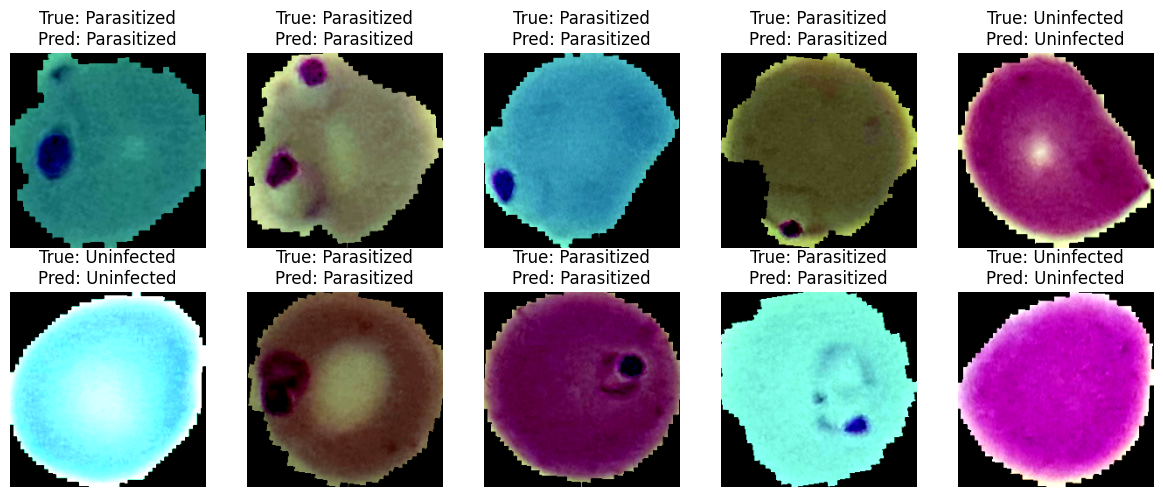

In [91]:
def show_predictions(model, dataloader, device, class_names=['Uninfected', 'Parasitized']):
    model.eval()
    imgs, labels = next(iter(dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    preds = torch.argmax(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(12,5))
    for i, ax in enumerate(axes.flatten()):
        img = imgs[i].permute(1,2,0).cpu().numpy()
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(resnet, test_loader, device)

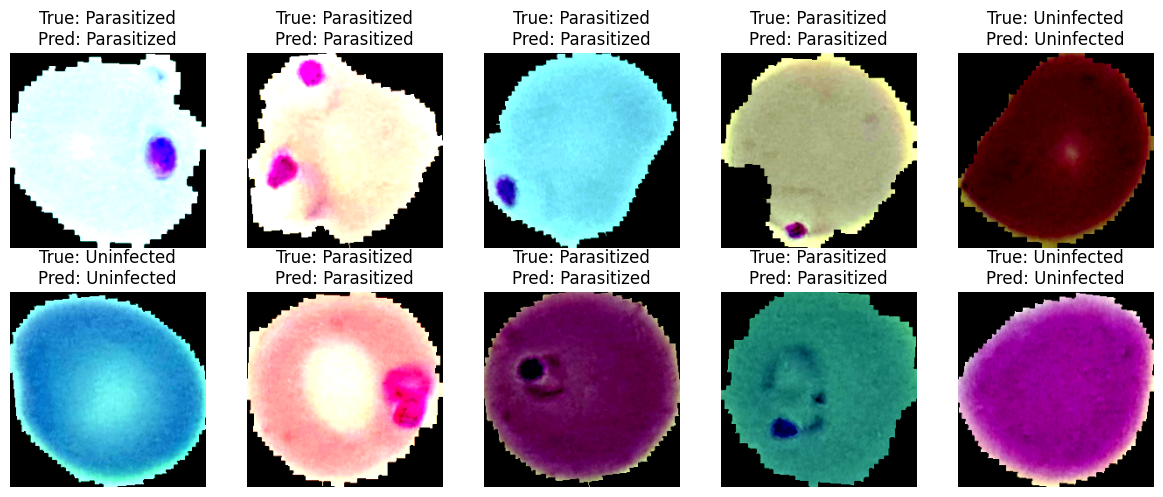

In [92]:
show_predictions(vgg19, test_loader, device)

### Save the model

In [93]:
# Create a folder called "saved_models" in the working directory
os.makedirs("/kaggle/working/saved_models", exist_ok=True)
print("Folder created successfully!")

Folder created successfully!


In [94]:
# Save ResNet
torch.save(resnet.state_dict(), "/kaggle/working/saved_models/resnet_model.pth")

# Save VGG19
torch.save(vgg19.state_dict(), "/kaggle/working/saved_models/vgg19_model.pth")

print("Models saved successfully in /kaggle/working/saved_models")

Models saved successfully in /kaggle/working/saved_models


In [95]:
!ls /kaggle/working/saved_models

resnet_model.pth  vgg19_model.pth


In [96]:
import shutil

shutil.make_archive('saved_models', 'zip', '/kaggle/working/saved_models')

'/kaggle/working/saved_models.zip'

In [97]:
from IPython.display import FileLink
FileLink(r'saved_models.zip')

/kaggle/working/saved_models.zip